In [ ]:
!pip install statsmodels

In [9]:
import numpy as np
from scipy.stats import bernoulli
import statsmodels.api as sm
import pandas as pd

def simulate_ar(n, p, beta=0.5):
    """
    Simulate an AR(1) process.
    n: Number of observations
    p: Number of variables
    beta: AR(1) coefficient
    """
    X = np.zeros((n, p))
    for i in range(p):
        X[0, i] = np.random.normal()
        for j in range(1, n):
            noise = np.random.normal()
            X[j, i] = beta * X[j-1, i] + noise
    return X

def compute_settings_output(X):
    """
    Compute the output for the two settings.
    """
    output_setting_1 = compute_setting1_output(X)
    output_setting_2 = compute_setting2_output(X)
    return output_setting_1, output_setting_2


def compute_setting1_output(X):
    """
    Y | X ~ Bernoulli(0.5)
    """
    return bernoulli.rvs(0.5, size=X.shape[0])

def compute_setting2_output(X):
    """
    Y | X ~ Bernoulli(logit(0.08*(X2 + ... + X21)))
    """
    linear_combination = 0.08 * np.sum(X[:, 1:21], axis=1)
    probability = 1 / (1 + np.exp(-linear_combination))
    return bernoulli.rvs(probability)

In [90]:
## version with numpy array
import numpy as np
import statsmodels.api as sm

# Assuming simulate_ar, compute_setting1_output, and compute_setting2_output are defined elsewhere

def simulation(iterations=1000, n=500, p=200):
    """
    Simulate the two Random variables and fit the models.
    n: Number of observations
    p: Number of variables
    iterations: Number of iterations
    """
    # Assuming p-1 because we're excluding the intercept
    total_rows = iterations * 2
    results = np.empty((total_rows, 5), dtype=object)  # Pre-allocate NumPy array
    
    idx = 0
    for i in range(iterations):
        
        if i % 100 == 0: print(f"Reached iteration {i}..")     
        try:
            xs = simulate_ar(n, p)
    
            ys1 = compute_setting1_output(xs)
            ys2 = compute_setting2_output(xs)
            
            model1 = sm.Logit(ys1, sm.add_constant(xs)).fit(disp=0)
            model2 = sm.Logit(ys2, sm.add_constant(xs)).fit(disp=0)
            
            # add only coeff beta1
            results[idx] = [i, 'Global Null', n, p, model1.pvalues[1]] 
            idx += 1
            results[idx] = [i, '20 Nonzero Coefficients', n, p, model2.pvalues[1]]
            idx += 1
    
        except np.linalg.LinAlgError:
            print(f"Skipping iteration {i} due to singular matrix error.")
            continue

        
        # code for all coeff pvalues
        # for j in range(p-1):  # Assuming len(model1_pvalues) is p-1
        #     results[idx] = [i, 'Global Null', n, p, model1_pvalues[j]]
        #     idx += 1
        #     results[idx] = [i, '20 Nonzero Coefficients', n, p, model2_pvalues[j]]
        #     idx += 1
        
    return results

results1 = simulation()

Running iteration 0..
Running iteration 100..
Running iteration 200..
Running iteration 300..
Running iteration 400..
Running iteration 500..
Running iteration 600..
Running iteration 700..
Running iteration 800..
Running iteration 900..


In [91]:
simulation_df = pd.DataFrame(columns=['SimIdx','Setting','n','p','coeff_pvalue'],data=results1)

Text(0.5, 1.0, 'Hisgoragram of Beta1: Global Null')

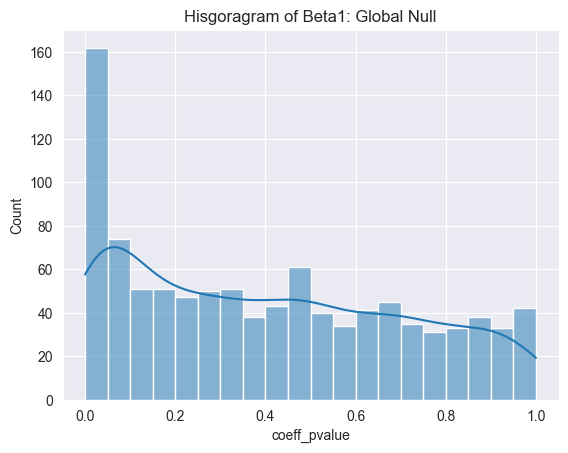

In [96]:
import seaborn as sns
sns.histplot(data=simulation_df[simulation_df['Setting'] == 'Global Null'], x='coeff_pvalue', kde=True, bins=20).set_title('Hisgoragram of Beta1: Global Null')

Text(0.5, 1.0, 'Histogram of Beta1 : 20 Nonzero Coefficients')

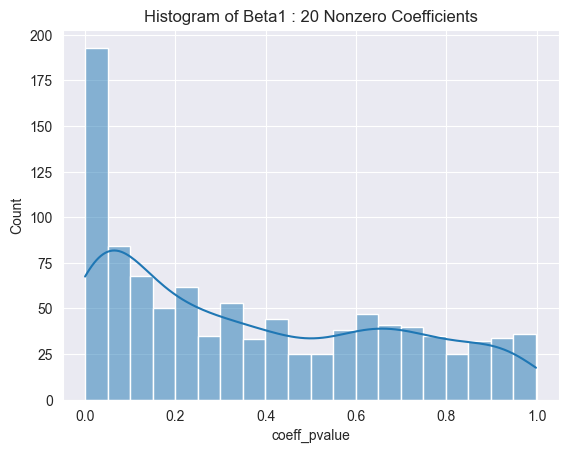

In [95]:
sns.histplot(data=simulation_df[simulation_df['Setting'] == '20 Nonzero Coefficients'], x='coeff_pvalue', kde=True, bins=20).set_title('Histogram of Beta1 : 20 Nonzero Coefficients')

Text(0.5, 1.0, 'Histogram of Beta1: Both Settings')

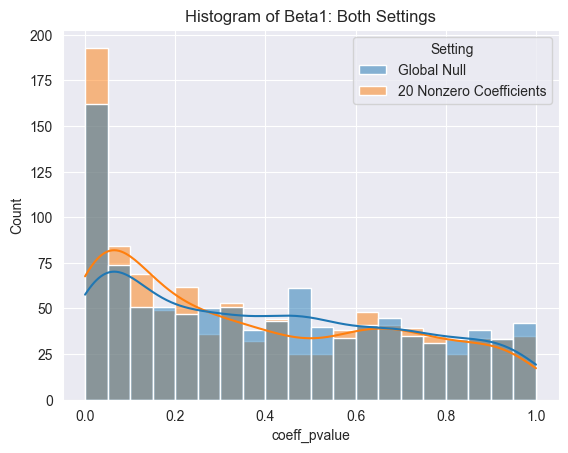

In [97]:
sns.histplot(data=simulation_df, x='coeff_pvalue',hue='Setting', kde=True, bins=20).set_title('Histogram of Beta1: Both Settings')

Version of simulation method with list (probably slower)

In [76]:
# shouldn't set seed, since want diff Xs for each iteration
# #np.random.seed(22) 
# def simulation(iterations = 100 ,n = 500, p = 200):
#     """
#     Simulate the two Random variables and fit the models.
#     n: Number of observations
#     p: Number of variables
#     iterations: Number of iterations
#     """
#     results = []
# 
#     for i in range(iterations):
#         xs = simulate_ar(n, p)
# 
#         ys1 = compute_setting1_output(xs)
#         ys2 = compute_setting2_output(xs)
# 
#         model1 = sm.Logit(ys1, sm.add_constant(xs)).fit(disp=0)
#         model2 = sm.Logit(ys2, sm.add_constant(xs)).fit(disp=0)
# 
#         model1_pvalues = model1.pvalues[1:] # exclude the intercept
#         model2_pvalues = model2.pvalues[1:]
# 
# 
#         for j in range(len(model1_pvalues)):        
# 
#             results.append([i,'Setting 1',n,p, model1_pvalues[j]]) 
#             results.append([i,'Setting 2',n,p, model2_pvalues[j]])
# 
# 
#     return results
# 
# results1 = simulation()